In [1]:
import cv2
import pytlsd
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from bresenham import bresenham

import torch
from dataset import TrainDataset
import segmentation_models_pytorch as smp
from config import cfg
from pprint import pprint
import pytorch_lightning as pl
from torchvision.ops import sigmoid_focal_loss

import pickle

## Parameters for Visualization

In [2]:
odgt = "datalist/testing_hypersim_short.odgt"
root_dataset = "./data"
model_name = "lightning_logs/version_0/checkpoints/epoch=14-step=7574.ckpt"
filename = "preview_predicted_15e_8b_resnet34_abs_sigmoid_BCE"
cfg.merge_from_file("config/params_hypersim.yaml")

list_sample = [json.loads(x.rstrip()) for x in open(odgt, 'r')]

In [3]:
class StructurenessModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        self.loss_fn = torch.nn.BCELoss()
        # self.loss_fn = torch.nn.MSELoss()
        # self.loss_fn = WMSELoss
        # self.loss_fn = sigmoid_focal_loss

    def forward(self, image):
        # normalize image
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32);
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes (1), height, width]
        assert mask.ndim == 4

        # Check that mask values in between -1 and 1
        assert mask.max() <= 1.0 and mask.min() >= -1.0

        logits_mask = self.forward(image)

        prob_mask = logits_mask.sigmoid()
        # loss = self.loss_fn(prob_mask, (mask+1)/2)
        loss = self.loss_fn(prob_mask, mask.abs())
        # loss = self.loss_fn(prob_mask, torch.clip(mask, min=0))
        # loss = self.loss_fn(prob_mask, (mask <= np.pi/4).float())

        # prob_mask = logits_mask.tanh()

        # loss = self.loss_fn(logits_mask, (mask+1)/2, reduction='mean')
        # loss = self.loss_fn(logits_mask, mask.abs(), reduction='mean')
        # loss = self.loss_fn(logits_mask, torch.clip(mask, min=0), reduction='mean')
        # loss = self.loss_fn(logits_mask, (mask <= np.pi/4).float(), reduction='mean')

        return {
            "loss": loss,
        }

    def shared_epoch_end(self, outputs, stage):

        metrics = {
            f"{stage}_loss_epoch": torch.mean(torch.tensor([x["loss"] for x in outputs]))
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch, "train") 
        self.log(f"train_loss", loss["loss"])
        return loss

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch, "valid") 
        self.log(f"valid_loss", loss["loss"])
        return loss

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        image = batch["image"]

        assert image.ndim == 4

        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        assert mask.ndim == 4
        assert mask.max() <= 1.0 and mask.min() >= -1.0

        logits_mask = self.forward(image)

        prob_mask = logits_mask.sigmoid()
        
        loss = self.loss_fn(prob_mask, mask.abs())
        # loss = self.loss_fn(prob_mask, (mask+1)/2)
        # loss = self.loss_fn(prob_mask, torch.clip(mask, min=0))
        # loss = self.loss_fn(prob_mask, (mask <= np.pi/4).float())

        # loss = self.loss_fn(logits_mask, mask.abs(), reduction='mean')
        # loss = self.loss_fn(logits_mask, torch.clip(mask, min=0), reduction='mean')
        # loss = self.loss_fn(logits_mask, (mask+1)/2, reduction='mean')
        # loss = self.loss_fn(logits_mask, (mask <= np.pi/4).float(), reduction='mean')

        # prob_mask = logits_mask.tanh()

        # loss = self.loss_fn(prob_mask, mask)

        # Save predicted normal difference
        prob_mask = prob_mask.squeeze(1)
        # logits_mask = logits_mask.squeeze(1)
        for i, savedir in enumerate(batch["savedir"]):
            dir = os.path.join(*savedir.split('/')[:-1])
            if not os.path.exists(dir):
                os.makedirs(dir)
            mask = torch.flip(prob_mask[i], [1]) if batch['flipped'][i] else prob_mask[i]
            # np.savez_compressed(savedir, normals_diff=(2*mask-1).cpu().numpy())
            np.savez_compressed(savedir, normals_diff=mask.cpu().numpy())
            # np.savez_compressed(savedir, normals_diff=torch.clamp(mask, min=-1, max=1).cpu().numpy())

        return {
            "loss": loss.item(),
        }

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

## Load Model

In [4]:
model = StructurenessModel.load_from_checkpoint(model_name, arch=cfg.MODEL.arch_decoder, encoder_name=cfg.MODEL.arch_encoder, in_channels=3, out_classes=1)
# model = StructurenessModel.load_from_checkpoint("abs_sigmoid_24e.ckpt", arch=cfg.MODEL.arch_decoder, encoder_name=cfg.MODEL.arch_encoder, in_channels=3, out_classes=1)

trainer = pl.Trainer(
    gpus=1, 
    max_epochs=0,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


## Extract per-pixel Prediction

In [51]:
test_dataset = TrainDataset(
    cfg.DATASET.root_dataset,
    cfg.DATASET.list_test,
    cfg.DATASET)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=cfg.TEST.batch_size,  # we have modified data_parallel
    shuffle=False,  # we do not use this param
    num_workers=cfg.TEST.workers,
    drop_last=False,
    pin_memory=True)

test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


# samples: 500


A Jupyter Widget

[{'test_loss_epoch': 0.14127279818058014}]


In [5]:
vis_idx = 9
degree = np.linspace(0., 90., 19)
thr = np.cos(degree * np.pi / 180.)
tp = np.zeros(len(thr))
fp = np.zeros(len(thr))
tn = np.zeros(len(thr))
fn = np.zeros(len(thr))

 30%|███       | 151/500 [02:10<05:02,  1.15it/s]


KeyboardInterrupt: 

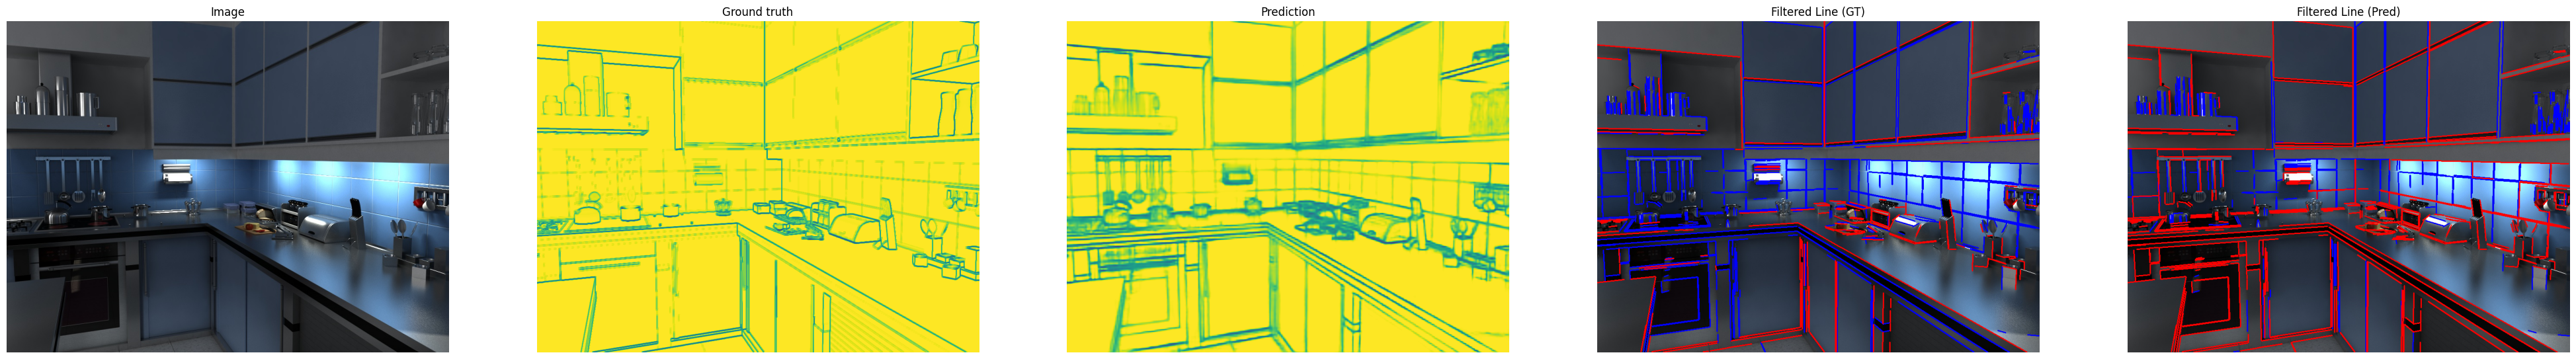

In [7]:
for sample in tqdm(list_sample):
    preview_file = os.path.join(root_dataset, sample['fpath_img'])

    paths = sample['fpath_img'].split('/')
    img_name = paths[-1]
    
    paths[2] = "pred_normals_diff"
    camnum = paths[3].split('_')[2]
    paths[3] = f"cam_{camnum}"
    paths[-1] = img_name + '.npz'
    # paths[-1] = '.'.join(img_name.split('.')[:2] + ['npz'])

    pred_file = os.path.join(root_dataset, *paths)
    # normal_diff = np.load(pred_file)['normals_diff']
    normal_diff = 2*np.load(pred_file)['normals_diff']-1


    paths[2] = "normals_diff"
    paths[-1] = '.'.join(img_name.split('.')[:2] + ['npz'])

    gt_file = os.path.join(root_dataset, *paths)
    gt_diff = np.load(gt_file)['normals_diff']

    # print(pred_file, gt_file, preview_file)

    img = cv2.imread(preview_file)
    original = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    flt_img = gray.astype(np.float64)

    segments = pytlsd.lsd(flt_img, 1.0)
    data = {'segments': segments}

    for segment in segments:
        cv2.line(img, (int(segment[0]), int(segment[1])), (int(segment[2]), int(segment[3])), (255, 0, 0), 2)
    img_gt = img.copy()

    flags = []
    gt_flags = []
    for i, seg in enumerate(segments):
        seg2d = seg[:4].astype(int)
        # if (10 > np.sqrt((seg2d[0] - seg2d[2]) * (seg2d[0] - seg2d[2]) + (seg2d[1] - seg2d[3]) * (seg2d[1] - seg2d[3]))):
        #     pass
        # print(gray.shape)

        seg_pts = np.array(list(bresenham(seg2d[0], seg2d[1], seg2d[2], seg2d[3])))
        seg_pts = seg_pts[(seg_pts[:, 0] >= 0) * (seg_pts[:, 1] >= 0) * (seg_pts[:, 0] < gray.shape[1]) * (seg_pts[:, 1] < gray.shape[0])]
        v = np.median(normal_diff[seg_pts[:,1], seg_pts[:,0]])
        gtv = np.median(gt_diff[seg_pts[:,1], seg_pts[:,0]])
        # v = np.mean(normal_diff[seg_pts[:,1], seg_pts[:,0]])

        if v < thr[vis_idx]:
            flags.append(True)
        else:
            flags.append(False)
        
        if gtv < thr[vis_idx]:
            gt_flags.append(True)
        else:
            gt_flags.append(False)


        for j, t in enumerate(thr):
            # if gtv < t:
            #     gt_flags.append(True)
            # else:
            #     gt_flags.append(False)

            # Except Binary
            tp[j] += v < t and gtv < t
            fp[j] += v < t and gtv >= t
            tn[j] += v >= t and gtv >= t
            fn[j] += v >= t and gtv < t

            # For Binary
            # tp[i] += v >= t and gtv >= t
            # fp[i] += v >= t and gtv < t
            # tn[i] += v < t and gtv < t
            # fn[i] += v < t and gtv >= t
    
            
    data['structure'] = flags
    for gf, f, segment in zip(gt_flags, flags, segments):
        if not f and not gf:
            continue
        if f:
            cv2.line(img, (int(segment[0]), int(segment[1])), (int(segment[2]), int(segment[3])), (0, 0, 255), 2)
        if gf:
            cv2.line(img_gt, (int(segment[0]), int(segment[1])), (int(segment[2]), int(segment[3])), (0, 0, 255), 2)
    
    
    paths[2] = "lines"
    paths.insert(4, filename)
    paths[-1] = img_name
    #print(os.path.join(root_dataset, *paths))

    dir = os.path.join(root_dataset, *paths[:-1])
    if not os.path.exists(dir):
        os.makedirs(dir)
    
    plt.figure(figsize=(50, 10))

    plt.subplot(1, 5, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 5, 2)
    plt.imshow((gt_diff+1)/2) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 5, 3)
    plt.imshow((normal_diff+1)/2) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.subplot(1, 5, 4)
    plt.imshow(cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)) # just squeeze classes dim, because we have only one class
    plt.title("Filtered Line (GT)")
    plt.axis("off")

    plt.subplot(1, 5, 5)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # just squeeze classes dim, because we have only one class
    plt.title("Filtered Line (Pred)")
    plt.axis("off")

    plt.savefig(os.path.join(root_dataset, *paths), bbox_inches='tight', pad_inches=0.1)
    plt.close()

    # fig = plt.figure(figsize=(16, 14))
    # fig.set_dpi(300)
    # plt.subplot(1, 2, 1)
    # plt.imshow((gt_diff+1)/2) # just squeeze classes dim, because we have only one class
    # plt.title("Ground truth")
    # plt.axis("off")
    # plt.savefig(os.path.join(root_dataset, *paths[:-1], paths[-1][:-4] + '_gt' + paths[-1][-4:]), bbox_inches='tight', pad_inches=0.1)
    # plt.close()

    # fig = plt.figure(figsize=(16, 14))
    # fig.set_dpi(300)
    # plt.subplot(1, 2, 2)
    # if 'binary' in filename:
    #     plt.imshow(1 - (normal_diff+1)/2) # just squeeze classes dim, because we have only one class
    # else:
    #     plt.imshow((normal_diff+1)/2)
    # plt.title("Prediction")
    # plt.axis("off")
    # plt.savefig(os.path.join(root_dataset, *paths[:-1], paths[-1][:-4] + '_pred' + paths[-1][-4:]), bbox_inches='tight', pad_inches=0.1)
    # plt.close()

In [75]:
precision = tp / (tp + fp + 1e-21)
recall_tpr = tp / (tp + fn + 1e-21)
fpr = fp / (fp + tn + 1e-21)
acc = (tp + tn) / (tp + tn + fp + fn + 1e-21)

In [76]:
print(precision[9])
print(recall_tpr[9])
print(fpr[9])
print(acc[9])

0.49487649126280875
0.7840345078707075
0.45083472717518225
0.6338003149097663


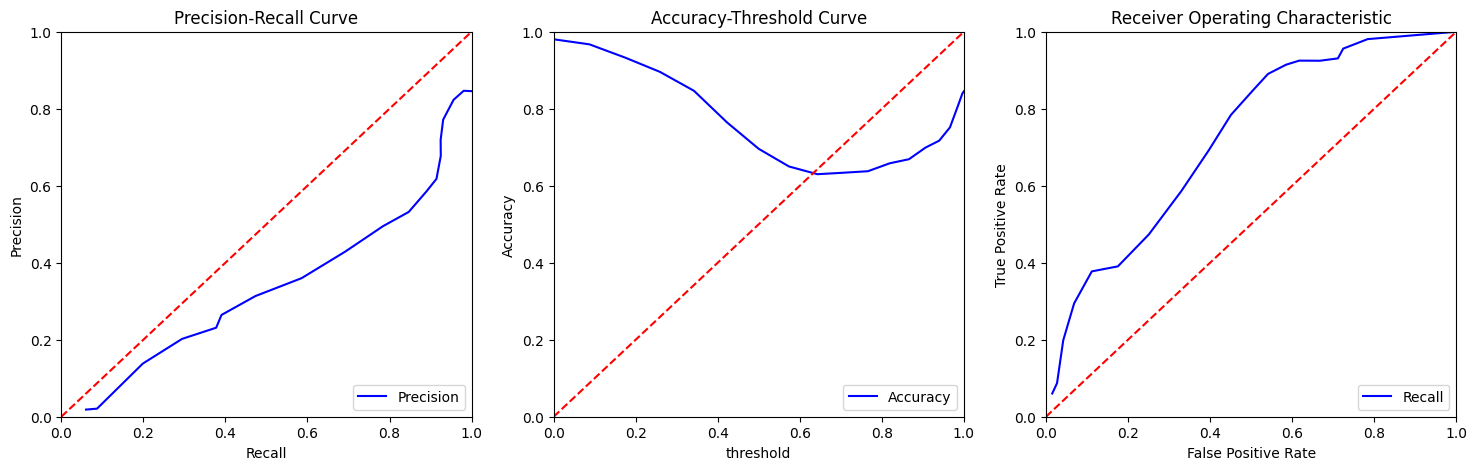

In [77]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.title('Precision-Recall Curve')
plt.plot(recall_tpr, precision, 'b', label = 'Precision')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')

plt.subplot(1, 3, 2)
plt.title('Accuracy-Threshold Curve')
plt.plot(thr, acc, 'b', label = 'Accuracy')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('threshold')

plt.subplot(1, 3, 3)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, recall_tpr, 'b', label = 'Recall')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [13]:
with open ('predictions/' + filename + '.pk', 'wb') as file:
    pickle.dump({
        'precision': precision,
        'recall': recall_tpr,
        'fpr': fpr,
        'acc': acc
    }, file, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
with open ('predictions/' + filename + '.pk', 'rb') as file:
    result = pickle.load(file)
    print(result)

{'precision': array([0.84540185, 0.61447997, 0.28515852, 0.10510129, 0.04985272,
       0.02683756, 0.00867979, 0.00237131, 0.        ]), 'recall': array([0.70543907, 0.6337974 , 0.53744966, 0.49456404, 0.58177083,
       0.73879142, 0.75      , 0.8       , 0.        ]), 'fpr': array([0.27667462, 0.3004054 , 0.30472471, 0.25015718, 0.17460734,
       0.11143093, 0.06367926, 0.0407696 , 0.01422746]), 'acc': array([0.71112681, 0.67127861, 0.66616335, 0.73552828, 0.82161573,
       0.88794865, 0.93618232, 0.95921111, 0.98577254])}
